In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

In [2]:
import os
import cv2
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 200

def get_training_data(data_dir,labels):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    
    # Separate images and labels and convert them to NumPy arrays
    images = np.array([i[0] for i in data]).astype('float32')
    labels = np.array([i[1] for i in data])
    data_merged = np.array(list(zip(images, labels)), dtype=object)
    return data_merged

# Loading the data
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train',labels)
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test',labels)
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val',labels)

print("Data loading complete.")


Data loading complete.


In [3]:
pnenumonia = 0 
normal = 0 

for i,j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


In [4]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [5]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [6]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

<h2 >CNN (Convolutional Neural Network) </h2>
Image source: https://www.researchgate.net/publication/321286547/figure/download/fig6/AS:564402564472832@1511575465150/A-convolutional-neural-networks-CNN.png

![](https://www.researchgate.net/publication/321286547/figure/download/fig6/AS:564402564472832@1511575465150/A-convolutional-neural-networks-CNN.png)

In [7]:
cnn = Sequential()

cnn.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# cnn.add(BatchNormalization(axis=1))

cnn.add(Conv2D(64, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# cnn.add(BatchNormalization(axis=1))

cnn.add(Conv2D(16, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# cnn.add(BatchNormalization(axis=1))

cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# cnn.add(Dropout(0.5))
cnn.add(Dense(64))
cnn.add(Activation('relu'))

# cnn.add(Dropout(0.5))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))
auc = AUC(name='auc')

adam = Adam(learning_rate=0.0001)
cnn.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc',auc])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 256)  │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 200, 200, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 799,441 (3.05 MB)

 Trainable params: 799,441 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:

# cnn_model = cnn.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=30)
cnn_model = cnn.fit(
    datagen.flow(X_train, y_train, batch_size=10),
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=2,
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732596960.725551      96 service.cc:145] XLA service 0x7e1e5400d530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732596960.725611      96 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732596960.725614      96 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732596966.454059      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1732596973.352717      99 asm_compiler.cc:369] ptxas warnin

375/375 - 32s - 85ms/step - acc: 0.7633 - auc: 0.7570 - loss: 0.4903 - val_acc: 0.8623 - val_auc: 0.9253 - val_loss: 0.3123
Epoch 2/100
375/375 - 16s - 42ms/step - acc: 0.8484 - auc: 0.9110 - loss: 0.3314 - val_acc: 0.8879 - val_auc: 0.9480 - val_loss: 0.2622
Epoch 3/100
375/375 - 16s - 43ms/step - acc: 0.8735 - auc: 0.9275 - loss: 0.3005 - val_acc: 0.9050 - val_auc: 0.9512 - val_loss: 0.2428
Epoch 4/100
375/375 - 16s - 43ms/step - acc: 0.8759 - auc: 0.9304 - loss: 0.2944 - val_acc: 0.8826 - val_auc: 0.9530 - val_loss: 0.2831
Epoch 5/100
375/375 - 17s - 45ms/step - acc: 0.8828 - auc: 0.9406 - loss: 0.2738 - val_acc: 0.9114 - val_auc: 0.9567 - val_loss: 0.2326
Epoch 6/100
375/375 - 18s - 47ms/step - acc: 0.8831 - auc: 0.9373 - loss: 0.2804 - val_acc: 0.9018 - val_auc: 0.9596 - val_loss: 0.2569
Epoch 7/100
375/375 - 19s - 51ms/step - acc: 0.8892 - auc: 0.9423 - loss: 0.2683 - val_acc: 0.9178 - val_auc: 0.9594 - val_loss: 0.2212
Epoch 8/100
375/375 - 18s - 49ms/step - acc: 0.8924 - auc: 0

In [10]:
cnn.evaluate(X_test, y_test)



37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - acc: 0.9264 - auc: 0.9874 - loss: 0.1780


[0.1930113583803177, 0.9240614175796509, 0.9836685061454773]

118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
[Summary Statistics]
Accuracy = 92.07% | Precision = 79.31% | Recall = 95.55% | Specificity = 90.79% | F1 Score = 86.68%


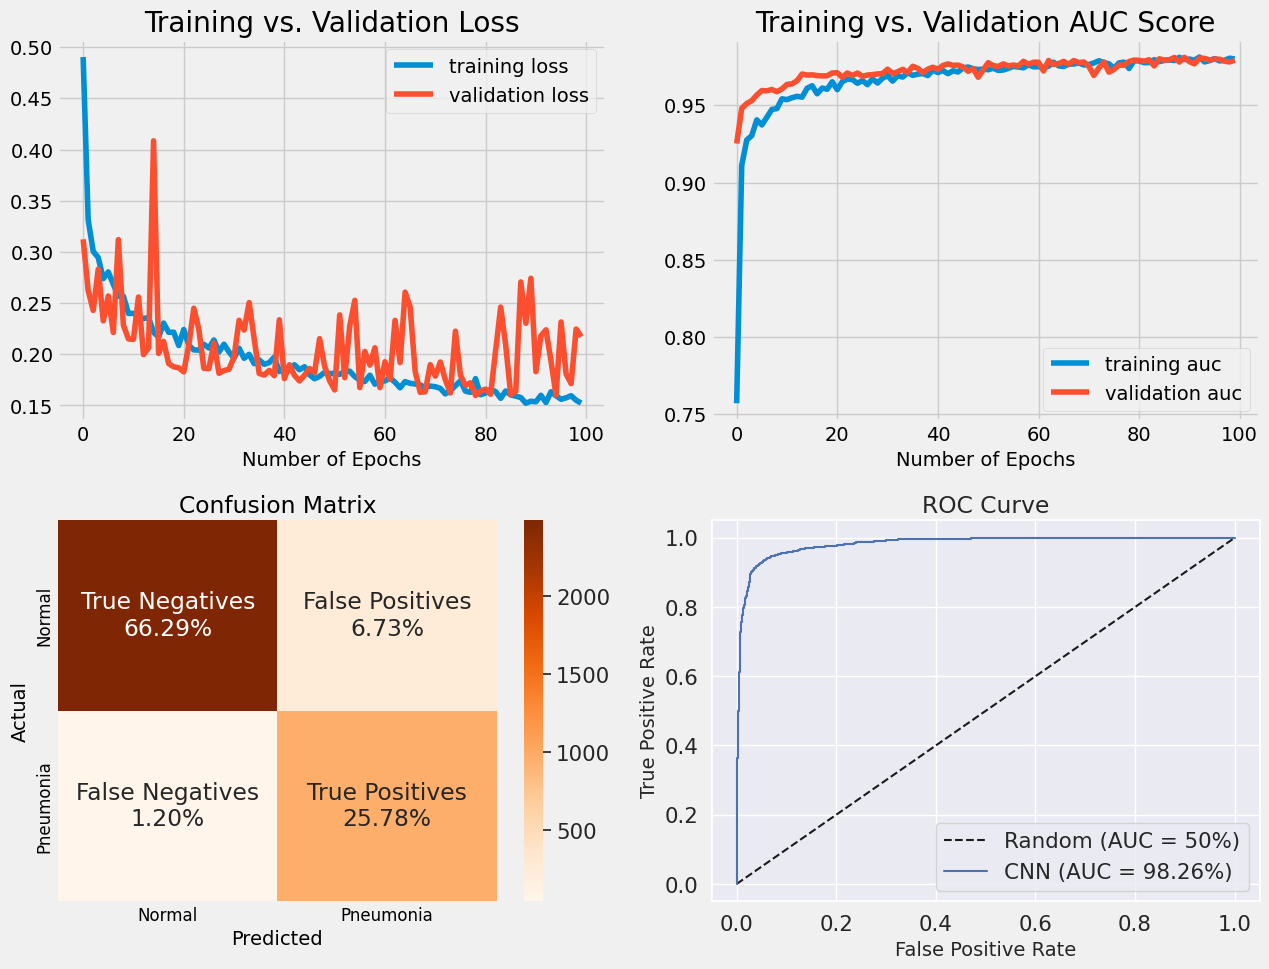

In [11]:
from sklearn.metrics import roc_auc_score
def create_charts(cnn, cnn_model):
    ## DEFINE ##
    ## Define 1:  train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define 2: train & validation AUC
    train_auc = cnn_model.history['auc']
    val_auc = cnn_model.history['val_auc']
    
    ## Define 3: y_pred & y_true
    y_true = X_test
    Y_pred = cnn.predict(X_train)
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_train, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
    auc = roc_auc_score(y_train, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    ;
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

create_charts(cnn, cnn_model)